# Node Embeddings of Disease Graph | Stellargraph Supervised

Here, we shall have a disease graph consisting of ICD10 codes as nodes (instead of the HCC codes as nodes), and assign these nodes their HCC codes as labels. Therefore, we shall have 10k+ nodes having 83 labels. Our task shall then be supervised. This ought to help us learn better node embeddings than the unsupervised task.

NOTE: Since there can be multiple HCCs tagged for a single ICD-10 code, the task will be multi-label classification.

***Links***
* Loading data in Stellargraph objects from Pandas - https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
* Algorithms for Task - https://stellargraph.readthedocs.io/en/v1.2.0/demos/index.html
* Node Classification with Directed GraphSAGE - https://stellargraph.readthedocs.io/en/v1.2.0/demos/node-classification/directed-graphsage-node-classification.html
* Unsupervised Representation Learning - https://stellargraph.readthedocs.io/en/stable/demos/embeddings/index.html#find-algorithms-and-demos-for-a-graph
* Unsupervised GraphSAGE & UnsupervisedSampler - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html
* Unsupervised DeepGraphInfoMax - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/deep-graph-infomax-embeddings.html
* Data Generators | Stellargraph - https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.mapper.CorruptedGenerator
* Creating multiple checkboxes in IPyWidgets - https://stackoverflow.com/questions/57219796/ipywidgets-dynamic-creation-of-checkboxes-and-selection-of-data
* 


In [1]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
import ipywidgets as widgets

import networkx as nx
from tensorflow import keras
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph.data import UnsupervisedSampler
from stellargraph import StellarGraph, StellarDiGraph, datasets, utils
from stellargraph.layer import GraphSAGE, DirectedGraphSAGE, link_classification , DeepGraphInfomax, GCN
from stellargraph.mapper import DirectedGraphSAGENodeGenerator

import warnings
from time import time
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

In [2]:
# constants
metadata_columns = ['Diagnosis Code','Description','CMS-HCC Model Category V24']
inpatient_data_columns = ['empi','visit_id','visit_start_date','primary_diagnosis']
outpatient_data_columns = ['empi','visit_id','last_date_of_service','primary_diagnosis']

# file paths
metadata_fp = "/workspaces/graphs/graphs-eda/data/metadata/2022 Midyear_Final ICD-10-CM Mappings.csv"
inpatient_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_preprocessed.csv"
outpatient_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_outpatient.csv"

In [5]:
def prepare_metadata(metadata_fp):
    """
    Reads, cleans and prepares the HCC metadata file
    """
    # reading the risk adjustment metadata file
    metadata = pd.read_csv(metadata_fp)

    # cleaning the risk adjustment metadata file
    metadata = metadata.iloc[2:-7,:]
    metadata.replace(r'\n',' ', regex=True, inplace=True)
    metadata.reset_index(drop=True, inplace=True)

    # creating the cleaned risk adjustment metadata dataframe
    new_metadata = pd.DataFrame(metadata.iloc[1:,:])
    new_metadata.columns = metadata.iloc[0,:].tolist()

    # filtering only the required columns from patient data and metadata
    new_metadata = new_metadata.loc[:,metadata_columns]
    new_metadata.columns = ['pd','dscr','hcc']
    new_metadata.loc[:,"hcc"] = new_metadata.hcc.fillna(0).astype('int')

    return new_metadata


def prepare_patient_data(inpatient_data_fp, outpatient_data_fp):
    """
    Reads and filters only the required columns from inpatient and outpatient data
    """
    # reading the inpatient and outpatient data 
    inpatient_data = pd.read_csv(inpatient_data_fp)
    outpatient_data = pd.read_csv(outpatient_data_fp)

    inpatient_data = inpatient_data.loc[:,inpatient_data_columns]
    outpatient_data = outpatient_data.loc[:,outpatient_data_columns]

    inpatient_data.columns = ['empi','vid','vdt','pd']
    outpatient_data.columns = ['empi','vid','vdt','pd']

    return inpatient_data, outpatient_data


def create_edge_table(data):
    """creates edge-table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = data.sort_values(['empi','vdt']).reset_index(drop=True)
    data["pd_nxt"] = data.pd.shift(-1)
    index_drop = data.groupby('empi').tail(1).index
    data = data.drop(index_drop)
    data = data[data.pd!=data.pd_nxt].reset_index(drop=True)

    data['edge'] = data.pd + ", " + data.pd_nxt
    data['cnt'] = 1

    edge_data = data.groupby(['pd','pd_nxt'], as_index=False).agg({'cnt':'count'})
    edge_data.columns = ['source','target','weight']

    return edge_data


def create_node_table(data):
    """Creates node table from data

    Args:
        data (_type_): _description_

    Returns:
        _type_: _description_
    """
    node_data = pd.DataFrame(data.pd.unique(), columns=['pd'])
    node_data.index = node_data.pd
    node_data.pd = 1
    return node_data


def remove_sparse_nodes(node_data, edge_data, n):
    """Removes edges having weight less than n 
    and then removes nodes having no edges connected
    to them
    """
    edge_data = edge_data[edge_data.weight>=n].reset_index(drop=True)
    filter1 = node_data.index.isin(edge_data.source.unique())
    filter2 = node_data.index.isin(edge_data.target.unique())
    node_data = node_data[filter1 | filter2]
    return node_data, edge_data


def create_stellargraph(node_data, edge_data):

    G = StellarDiGraph({"node":node_data}, {"edge":edge_data})
    return G


def create_node_labels(node_data):
    node_labels = pd.DataFrame(node_data.index, columns=['pd'])
    node_labels = node_labels.merge(metadata[['pd','hcc']], on='pd',how='left')
    node_labels = node_labels.replace({0:np.nan})
    node_labels = node_labels.dropna()
    node_labels = node_labels.fillna(0)

    node_labels_dummies_temp = pd.get_dummies(node_labels.hcc)
    aggregate_dict = dict(zip(node_labels_dummies_temp.columns, ['sum'] * node_labels_dummies_temp.shape[1]))
    node_labels_dummies = pd.concat([node_labels[['pd']], node_labels_dummies_temp], axis=1).groupby('pd').aggregate(aggregate_dict)
    return node_labels_dummies


def create_node_features(node_data, edge_data):
    """Create node features

    Args:
        node_data (_type_): _description_
        edge_data (_type_): _description_
    """
    Gd = create_stellargraph(node_data, edge_data).to_networkx()
    Gu = StellarGraph(node_data, edge_data).to_networkx()
    node_features_dict = {}

    node_features_dict["in_degree_centrality"] = nx.in_degree_centrality(Gd)
    print("in_degree_centrality computed")
    node_features_dict["out_degree_centrality"] = nx.out_degree_centrality(Gd)
    print("out_degree_centrality computed")
    node_features_dict["load_centrality"] = nx.load_centrality(Gd)
    print("load_centrality computed")
    node_features_dict["eigenvector_centrality_numpy"] = nx.eigenvector_centrality_numpy(Gd)
    print("eigenvector_centrality_numpy computed")
    node_features_dict["closeness_centrality"] = nx.closeness_centrality(Gd)
    print("closeness_centrality computed")
    node_features_dict["betweenness_centrality_source"] = nx.betweenness_centrality_source(Gd)
    print("betweenness_centrality_source computed")
    node_features_dict["harmonic_centrality"] = nx.harmonic_centrality(Gd)
    print("harmonic_centrality computed")
    node_features_dict["pagerank"] = nx.pagerank_numpy(Gd)
    print("pagerank computed")
    node_features_dict["average_neighbor_degree"] = nx.average_neighbor_degree(Gd)
    print("average_neighbor_degree computed")
    node_features_dict["node_clique_number"] = nx.node_clique_number(Gu)
    print("node_clique_number computed")
    node_features_dict["hits_numpy"] = nx.hits_numpy(Gd)[0]
    print("hits_numpy computed")

    data = pd.DataFrame({'in_degree_centrality':pd.Series(node_features_dict['in_degree_centrality'])})
    for key, value in node_features_dict.items():
        data[key] = pd.Series(value)
    return data


def filter_edge_data_by_node(node, edge_data):
    n_i = edge_data.columns[0]
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_i]==node
    filter2 = edge_data[n_j]==node
    return edge_data[filter1 | filter2].sort_values(weight)


def filter_edge_data_by_source_node(node, edge_data):

    filter1 = edge_data.source==node
    return edge_data[filter1].sort_values('weight')


def filter_edge_data_by_target_node(node, edge_data):
    n_j = edge_data.columns[1]
    weight = edge_data.columns[2]
    filter1 = edge_data[n_j]==node
    return edge_data[filter1].sort_values(weight)

In [6]:
# preparing cleaned risk adjustment metadata
metadata = prepare_metadata(metadata_fp)

# filtering only the required columns from inpatient and outpatient data
inpatient_data, outpatient_data = prepare_patient_data(inpatient_data_fp, outpatient_data_fp)

In [5]:
inpatient_data

,empi,vid,vdt,pd
0,M0000040556,nM0000040556:1088927097671487508,2018-01-20,K5641
1,M0000040556,nM0000040556:1801256381439324181,2018-02-04,G458
2,M0000040556,nM0000040556:1339948222969081413,2018-02-18,K254
3,M0000040556,nM0000040556:1014145580172622435,2018-04-13,R5381
4,M0000040556,nM0000040556:130095445752129940,2018-06-27,I160
...,...,...,...,...
20536,M9993733479,nM9993733479:102570510608313553,2019-06-01,A401
20537,M9993964586,nM9993964586:1128306804831807937,2018-09-16,N132
20538,M9994944874,nM9994944874:1045976241917563056,2018-09-09,C786
20539,M9994944874,nM9994944874:1128135899864448921,2018-09-30,K5900


In [17]:
metadata = metadata[metadata.hcc!=0]
metadata

,pd,dscr,hcc
1,A0103,Typhoid pneumonia,115
2,A0104,Typhoid arthritis,39
3,A0105,Typhoid osteomyelitis,39
4,A021,Salmonella sepsis,2
5,A0222,Salmonella pneumonia,115
...,...,...,...
10977,Z95811,Presence of heart assist device,186
10978,Z95812,Presence of fully implantable artificial heart,186
10979,Z9911,Dependence on respirator [ventilator] status,82
10980,Z9912,Encounter for respirator [ventilator] dependen...,82


In [30]:
data_temp = inpatient_data.merge(metadata, how='left')
data_temp[data_temp.pd.isin(metadata.pd.value_counts().head(278).index)]

,empi,vid,vdt,pd,dscr,hcc
148,M0088832648,nM0088832648:2165461251679696065,2018-10-24,E11622,Type 2 diabetes mellitus with other skin ulcer,18.0
149,M0088832648,nM0088832648:2165461251679696065,2018-10-24,E11622,Type 2 diabetes mellitus with other skin ulcer,161.0
185,M011307912,nM011307912:2177022335744962607,2018-09-13,I132,Hypertensive heart and chronic kidney disease ...,85.0
186,M011307912,nM011307912:2177022335744962607,2018-09-13,I132,Hypertensive heart and chronic kidney disease ...,136.0
187,M011307912,nM011307912:1798437072425410324,2018-09-19,I132,Hypertensive heart and chronic kidney disease ...,85.0
...,...,...,...,...,...,...
20571,M9832317848,nM9832317848:1350950016110075880,2019-06-10,I132,Hypertensive heart and chronic kidney disease ...,136.0
20796,M9935138031,nM9935138031:2408479825372710892,2018-07-10,K50912,"Crohn's disease, unspecified, with intestinal ...",33.0
20797,M9935138031,nM9935138031:2408479825372710892,2018-07-10,K50912,"Crohn's disease, unspecified, with intestinal ...",35.0
20809,M9943216123,nM9943216123:1161583832719245971,2018-11-27,I132,Hypertensive heart and chronic kidney disease ...,85.0


In [34]:
data_temp.shape[0] - inpatient_data.shape[0]

356

In [7]:
data_combined = pd.concat([inpatient_data, outpatient_data], axis=0)
edge_data = create_edge_table(data_combined)
node_data = create_node_table(data_combined)

In [8]:
print(f"Graph info before removing sparse nodes\n{create_stellargraph(node_data, edge_data).info()}")
node_data, edge_data = remove_sparse_nodes(node_data, edge_data, 5)

Graph info before removing sparse nodes
StellarDiGraph: Directed multigraph
 Nodes: 7095, Edges: 94165

 Node types:
  node: [7095]
    Features: float32 vector, length 1
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [94165]
        Weights: range=[1, 342], mean=1.72311, std=4.09551
        Features: none


In [9]:
node_features = create_node_features(node_data, edge_data)
node_data = pd.concat([node_data,node_features], axis=1).drop('pd', axis=1)

in_degree_centrality computed
out_degree_centrality computed
load_centrality computed
eigenvector_centrality_numpy computed
closeness_centrality computed
betweenness_centrality_source computed
harmonic_centrality computed
pagerank computed
average_neighbor_degree computed
node_clique_number computed
hits_numpy computed


In [38]:
node_data.to_csv("disease_node_features.csv")

In [10]:
G = create_stellargraph(node_data, edge_data)
print(f"\nGraph info after removing sparse nodes\n{G.info()}")


Graph info after removing sparse nodes
StellarDiGraph: Directed multigraph
 Nodes: 699, Edges: 4188

 Node types:
  node: [699]
    Features: float32 vector, length 11
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [4188]
        Weights: range=[5, 342], mean=11.8281, std=16.1884
        Features: none


In [11]:
node_labels_dummies = create_node_labels(node_data)
node_labels_dummies.shape

(353, 58)

In [12]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_labels_dummies, train_size=0.8
)

In [13]:
train_targets = np.array(train_subjects)
test_targets = np.array(test_subjects)

In [14]:
batch_size = 50
in_samples = [7, 5]
out_samples = [7, 5]

In [15]:
generator = DirectedGraphSAGENodeGenerator(G, batch_size, in_samples, out_samples)

In [16]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [17]:
layer_sizes = [32, 16]
graphsage_model = DirectedGraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=False, dropout=0.2,
)

In [18]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [19]:
model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.005),
    loss=keras.losses.categorical_crossentropy,
    metrics=["acc"],
)

In [20]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [21]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_acc", patience=200, restore_best_weights=True)

history = model.fit(
    train_gen, 
    epochs=1000, 
    validation_data=test_gen, 
    verbose=2, 
    shuffle=False,
    callbacks=[es_callback]
)

Epoch 1/1000
6/6 - 5s - loss: 4.1272 - acc: 0.0319 - val_loss: 4.0384 - val_acc: 0.0282
Epoch 2/1000
6/6 - 1s - loss: 4.0136 - acc: 0.0638 - val_loss: 3.9855 - val_acc: 0.0423
Epoch 3/1000
6/6 - 1s - loss: 3.9247 - acc: 0.0674 - val_loss: 3.9521 - val_acc: 0.0423
Epoch 4/1000
6/6 - 1s - loss: 3.8580 - acc: 0.0603 - val_loss: 3.9191 - val_acc: 0.0423
Epoch 5/1000
6/6 - 1s - loss: 3.7903 - acc: 0.0603 - val_loss: 3.8942 - val_acc: 0.0563
Epoch 6/1000
6/6 - 1s - loss: 3.7295 - acc: 0.0674 - val_loss: 3.8718 - val_acc: 0.0423
Epoch 7/1000
6/6 - 1s - loss: 3.6816 - acc: 0.0816 - val_loss: 3.8557 - val_acc: 0.0704
Epoch 8/1000
6/6 - 1s - loss: 3.6281 - acc: 0.0993 - val_loss: 3.8455 - val_acc: 0.0704
Epoch 9/1000
6/6 - 1s - loss: 3.5856 - acc: 0.1099 - val_loss: 3.8399 - val_acc: 0.0704
Epoch 10/1000
6/6 - 1s - loss: 3.5534 - acc: 0.1135 - val_loss: 3.8381 - val_acc: 0.0704
Epoch 11/1000
6/6 - 1s - loss: 3.5251 - acc: 0.1135 - val_loss: 3.8393 - val_acc: 0.0704
Epoch 12/1000
6/6 - 1s - loss:

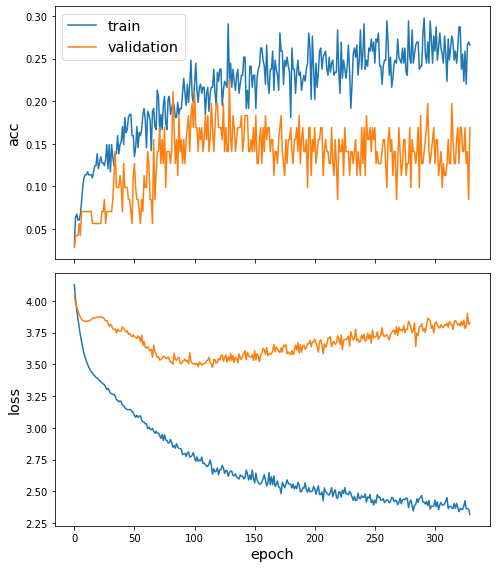

In [22]:
utils.plot_history(history)

In [23]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 0s 18ms/step - loss: 3.5395 - acc: 0.1831

Test Set Metrics:
	loss: 3.5395
	acc: 0.1831


In [24]:
embedding_model = keras.Model(inputs=x_inp, outputs=x_out)

In [25]:
all_nodes = node_labels_dummies.index
all_mapper = generator.flow(all_nodes)
emb = embedding_model.predict(all_mapper)
emb.shape

(353, 16)

In [26]:
transform = TSNE  # PCA

trans = transform(n_components=2)
emb_tsne = pd.DataFrame(trans.fit_transform(emb), index=node_labels_dummies.index)

In [27]:
emb_tsne.index.name = ''
emb_tsne['pd'] = emb_tsne.index
emb_tsne = emb_tsne.merge(metadata[['pd','hcc']], on='pd', how='left')
emb_tsne

,0,1,pd,hcc
0,24.095854,21.134417,A4101,2
1,24.199066,21.485693,A4102,2
2,10.998810,10.699273,A4151,2
3,8.572713,12.681742,A419,2
4,22.856304,26.667109,B20,1
...,...,...,...,...
365,-7.889719,10.217579,Z4824,186
366,-8.063200,7.319942,Z942,186
367,-10.226534,-0.412648,Z944,186
368,6.646356,9.222461,Z95811,186


In [28]:
data = emb_tsne.hcc.sort_values().unique().tolist()
checkboxes = [widgets.Checkbox(value=False, description=str(label)) for label in data]
output = widgets.VBox(children=checkboxes)

In [44]:
n = len(checkboxes)//6

HBox([
    VBox(checkboxes[:n]),
    VBox(checkboxes[n:2*n]),
    VBox(checkboxes[2*n:3*n]),
    VBox(checkboxes[3*n:4*n]),
    VBox(checkboxes[4*n:5*n]),
    VBox(checkboxes[5*n:])
])

In [45]:
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
selected_data = [float(i) for i in selected_data]
print(selected_data)

[84.0, 85.0, 86.0, 87.0, 88.0, 96.0, 100.0]


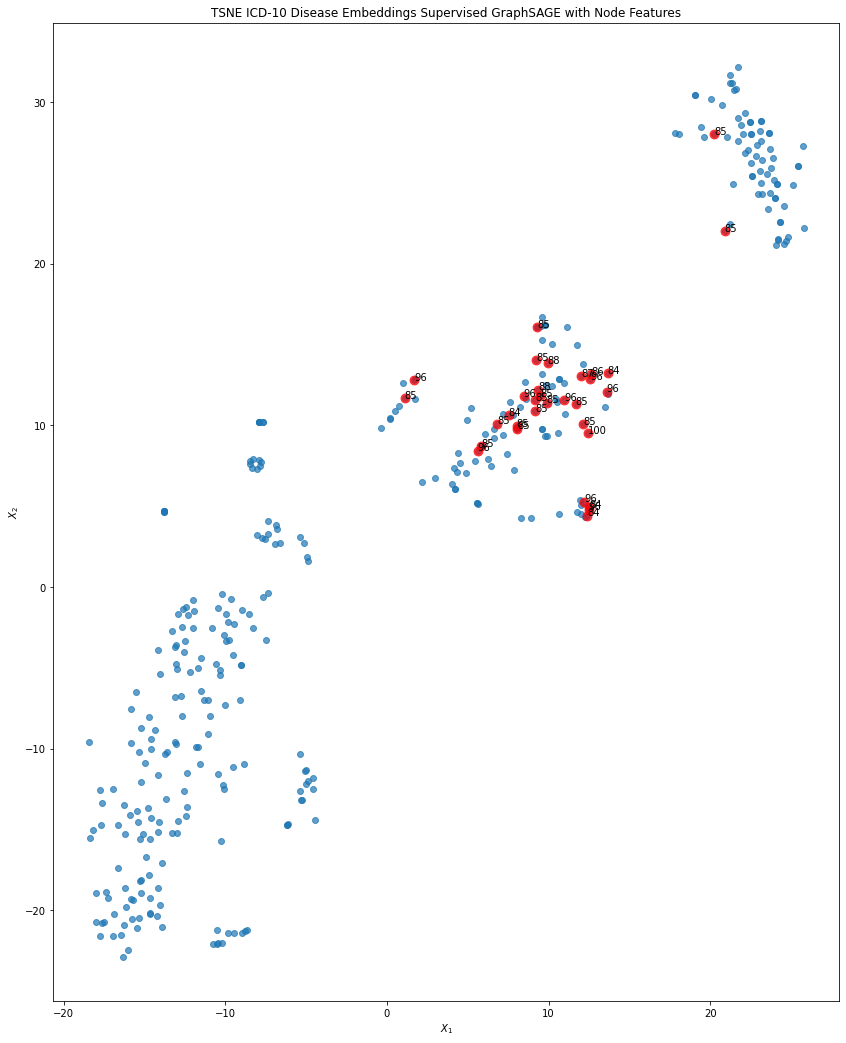

In [46]:
alpha = 0.7
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(
    emb_tsne[0],
    emb_tsne[1],
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} ICD-10 Disease Embeddings Supervised GraphSAGE with Node Features".format(transform.__name__)
)
selected_data_embeddings = emb_tsne[emb_tsne.hcc.isin(selected_data)]
for i, row in selected_data_embeddings.iterrows():
    plt.annotate(row['hcc'], (row[0],row[1]))
    ax.scatter(
    row[0],
    row[1],
    c='red',
    s=80,
    alpha=alpha,
    )
plt.show()

In [127]:
# cancer 8, 9, 10, 11, 12
# 51, 52, 57, 59 [Mental Diseases - dementia, schizophrenia, depression]
# 84,85,86,87,88,96,100 [heart diseases]
# 134, 135, 136, 137 [Kidney Diseases - Dialysis, Acute Renal failure, CKD]
# 176, 186, 188, 189 [artifical opening, organ transplant, surgery, amputation]
# 17,18,19 [Diabetes]


# 157, 158, 159, 161 [Ulcers]
# 107-115 Vascular diseases


In [339]:
emb_tsne.hcc.fillna(0)isna().sum()/emb_tsne.shape[0]

0.6602456728084869

In [341]:
emb_tsne[emb_tsne.hcc.fillna(0)==0].shape[0]/emb_tsne.shape[0]

0.7014237855946399